In [146]:
# === Imports === #
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from captum.attr import IntegratedGradients, NoiseTunnel, Saliency, NeuronConductance, KernelShap, Lime
from captum.robust import FGSM, PGD, MinParamPerturbation
from captum.metrics import infidelity, sensitivity_max
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
# === Reproducibility === #
torch.manual_seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

In [148]:
# === Dataset Wrapper === #
class RatingsDataset(Dataset):
    def __init__(self, X, y):
        self.cat_data = torch.tensor(X[cat_features].values, dtype=torch.long)
        self.cont_data = torch.tensor(X[cont_features].values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.cat_data[idx], self.cont_data[idx], self.labels[idx]

In [149]:
# === Model Definition === #
class MovieRatingModel(nn.Module):
    def __init__(self, cat_dims, cont_dim, emb_dim=16):
        super().__init__()
        # Embedding layers for categorical features
        self.embeddings = nn.ModuleList([nn.Embedding(dim, emb_dim) for dim in cat_dims])
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(emb_dim * len(cat_dims) + cont_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_cat, x_cont):
        # Concatenate embeddings and continuous features
        x = torch.cat([emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)], dim=1)
        return self.fc(torch.cat([x, x_cont], dim=1)).squeeze()

In [150]:
# === Model Initialization and Training === #
cat_dims = [len(label_encoders[col].classes_) for col in cat_features]  # Dimension of each categorical embedding
cont_dim = len(cont_features)
model = MovieRatingModel(cat_dims, cont_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [151]:
# Training loop
model.train()
for epoch in range(5):
    total_loss = 0
    for x_cat, x_cont, yb in train_loader:
        preds = model(x_cat, x_cont)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 672.9036
Epoch 2: Loss = 504.5694
Epoch 3: Loss = 492.0899
Epoch 4: Loss = 480.5582
Epoch 5: Loss = 459.0596


In [152]:
# === Model Evaluation === #
model.eval()
with torch.no_grad():
    x_cat, x_cont, yb = next(iter(DataLoader(test_dataset, batch_size=64)))
    preds = model(x_cat, x_cont)
    mae = torch.mean(torch.abs(preds - yb))
    mse = torch.mean((preds - yb) ** 2)
    rmse = torch.sqrt(mse)
    r2 = 1 - (torch.sum((yb - preds) ** 2) / torch.sum((yb - torch.mean(yb)) ** 2))
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")

MAE: 0.8715, MSE: 1.1276, RMSE: 1.0619, R^2: 0.1200


In [184]:
# === Robustness: Minimum Parameter Perturbation using FGSM === #
attack = FGSM(model.fc)

def patched_perturb(inputs, epsilon, target=None):
    target_class = torch.tensor([0], dtype=torch.long)
    return FGSM(model.fc).perturb(inputs, epsilon=epsilon, target=target_class)

attack.perturb = patched_perturb

min_perturb = MinParamPerturbation(
    forward_func=model.fc,
    attack=attack,
    arg_name="epsilon",
    arg_min=0.001,
    arg_max=0.1,
    arg_step=0.005
)

robust_result = min_perturb.evaluate(
    full_input,
    target=target_output
)

print("Minimum Parameter Perturbation (linf norm):", robust_result)

Minimum Parameter Perturbation (linf norm): (tensor([[-1.5137,  0.5829, -0.8281,  1.1260,  0.9318,  0.3189, -0.2349, -1.1208,
          0.8553, -1.2472,  1.2111,  1.2559, -0.3855,  0.9397,  0.1176,  0.3517,
          0.7992,  0.6426, -0.9413, -0.2553,  0.7363, -0.6740, -0.5446,  0.0796,
          0.3846,  1.1798,  0.0237, -1.2174,  0.5153,  1.2943, -1.1272,  0.6603,
         -0.8745, -2.3186, -0.7681, -0.1064, -1.4103,  0.1158, -1.6599, -1.6013,
          1.1181, -0.0116, -0.4823, -0.7495,  0.7248,  0.5056,  0.9527,  1.3273,
          0.2319,  0.4303,  0.7947,  1.1884,  1.1808, -1.4210,  0.7067, -0.3441,
         -0.0818, -1.6010, -0.3513,  0.2472, -1.1504, -0.7333, -0.9124,  0.6375,
          0.5478,  0.4330,  0.1835,  0.9303,  0.2841,  1.9295,  0.2755, -1.1868,
         -0.6361, -0.3796, -0.6763,  0.8923, -1.9122, -1.2298,  0.2850,  0.0602,
          0.6091, -0.9073,  0.8966,  1.2540, -1.3009,  0.2605,  0.4254,  0.3534,
          0.8270, -1.2575, -0.5372, -0.1173, -0.8119,  0.8586,  

In [191]:
# === Infidelity Metric using Saliency === #
perturb_fn = lambda inputs: (
    torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float(),
    inputs - torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float(),
)

sal = Saliency(model.fc)
attr_sal = sal.attribute(full_input)
infid = infidelity(model.fc, perturb_fn, full_input, attr_sal)
print("Infidelity Score:", infid.item())

Infidelity Score: 9.175879313261248e-06


In [196]:
# === SHAP and LIME Attributions === #
kernel_shap = KernelShap(model.fc)
lime = Lime(model.fc)

# Compute SHAP and LIME on a single test input
shap_attr = kernel_shap.attribute(full_input, n_samples=50).detach().numpy().flatten()
lime_attr = lime.attribute(full_input, n_samples=50).detach().numpy().flatten()

all_features = cat_features + cont_features

# Create a dataframe to visualize attributions
df_attr = pd.DataFrame({
    'Feature': all_features,
    'SHAP Attribution': shap_attr[:len(all_features)],
    'LIME Attribution': lime_attr[:len(all_features)],
    'Feature Value': X_test.iloc[0][all_features].values
})

# Sort by SHAP attribution magnitude
df_attr_sorted = df_attr.sort_values(by='SHAP Attribution', key=lambda col: np.abs(col), ascending=False)
print("\nTop Feature Attributions (SHAP and LIME):")
print(df_attr_sorted.head(10))


Top Feature Attributions (SHAP and LIME):
              Feature  SHAP Attribution  LIME Attribution  Feature Value
10            revenue          0.184711          0.004654      -0.195342
4   original_language          0.116682          0.010149       9.000000
11            runtime          0.084924          0.018133       0.869863
8          popularity          0.060107          0.000000      -0.186594
3          occupation          0.053094          0.000000      14.000000
9              budget          0.051873          0.000000       0.069927
13         vote_count         -0.040737          0.000000      -0.138320
0             user_id          0.039299          0.000000    6395.000000
12       vote_average         -0.033162          0.000000       0.856538
5              status          0.028316          0.000000       1.000000


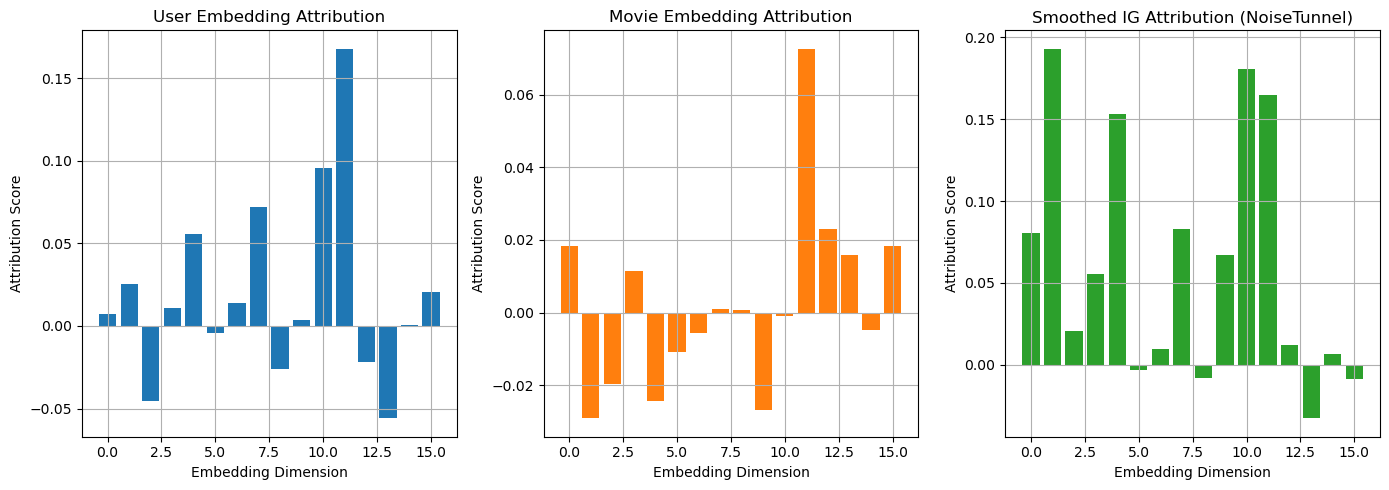


Convergence Delta: 0.002543


In [ ]:
# === Plotting Attribution Scores === #
def plot_bar(attr, title, color):
    plt.bar(np.arange(len(attr)), attr, color=color)
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Attribution Score")
    plt.title(title)
    plt.grid(True)

x_cat, x_cont, _ = test_dataset[0]
x_cat = x_cat.unsqueeze(0)
x_cont = x_cont.unsqueeze(0)

embedded_list = []
for i, emb_layer in enumerate(model.embeddings):
    cat_emb = emb_layer(x_cat[:, i])
    embedded_list.append(cat_emb)

embedded_cat = torch.cat(embedded_list, dim=1)
full_input = torch.cat([embedded_cat, x_cont], dim=1).requires_grad_()

ig = IntegratedGradients(model.fc)
attributions, delta = ig.attribute(
    full_input,
    baselines=torch.zeros_like(full_input),
    n_steps=10,
    return_convergence_delta=True
)

emb_dim = 16
user_attr = attributions[0, 0:emb_dim].detach().cpu().numpy()
movie_attr = attributions[0, emb_dim:2*emb_dim].detach().cpu().numpy()

nt = NoiseTunnel(ig)
smoothed_attributions = nt.attribute(
    full_input,
    baselines=torch.zeros_like(full_input),
    n_steps=10,
    nt_type='smoothgrad'
)
smoothed_user_attr = smoothed_attributions[0, 0:emb_dim].detach().cpu().numpy()

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plot_bar(user_attr, "User Embedding Attribution", color="tab:blue")
plt.subplot(1, 3, 2)
plot_bar(movie_attr, "Movie Embedding Attribution", color="tab:orange")
plt.subplot(1, 3, 3)
plot_bar(smoothed_user_attr, "Smoothed IG Attribution (NoiseTunnel)", color="tab:green")
plt.tight_layout()
plt.show()

print(f"\nConvergence Delta: {delta.item():.6f}")


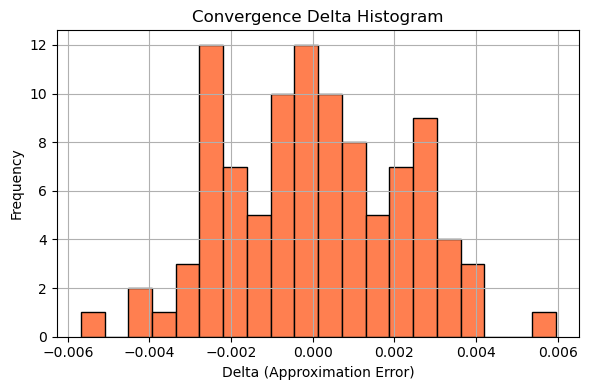

In [181]:
# === Convergence Delta Histogram === #
ig = IntegratedGradients(model.fc)

def plot_convergence_deltas(model, dataset, ig):
    deltas = []
    for i in range(100):
        x_cat, x_cont, _ = dataset[i]
        x_cat = x_cat.unsqueeze(0)
        x_cont = x_cont.unsqueeze(0)
        embedded = torch.cat([emb(x_cat[:, i]) for i, emb in enumerate(model.embeddings)], dim=1)
        full_input = torch.cat([embedded, x_cont], dim=1).requires_grad_()
        baseline = torch.zeros_like(full_input)
        _, delta = ig.attribute(full_input, baselines=baseline, return_convergence_delta=True)
        deltas.append(delta.item())

    # Plot convergence deltas
    plt.figure(figsize=(6, 4))
    plt.hist(deltas, bins=20, color="coral", edgecolor="black")
    plt.title("Convergence Delta Histogram")
    plt.xlabel("Delta (Approximation Error)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_convergence_deltas(model, test_dataset, ig)

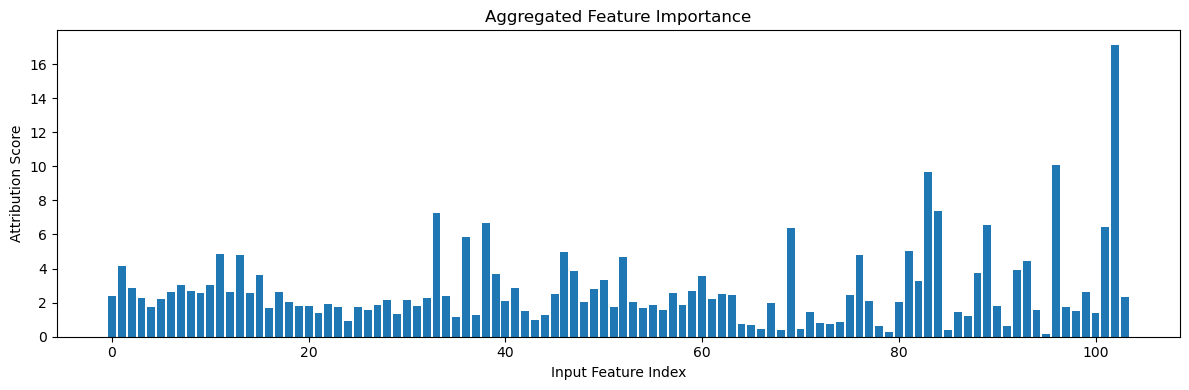

In [178]:
# === Aggregated Feature Importance (Batch-wise) === #
x_cat_batch, x_cont_batch, _ = next(iter(DataLoader(test_dataset, batch_size=64)))
embedded_batch = torch.cat([emb(x_cat_batch[:, i]) for i, emb in enumerate(model.embeddings)], dim=1)
full_input_batch = torch.cat([embedded_batch, x_cont_batch], dim=1).requires_grad_()

attr_batch = ig.attribute(full_input_batch, baselines=torch.zeros_like(full_input_batch), n_steps=10)
feature_importance = attr_batch.abs().sum(dim=0).detach().cpu()

plt.figure(figsize=(12, 4))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title("Aggregated Feature Importance")
plt.xlabel("Input Feature Index")
plt.ylabel("Attribution Score")
plt.tight_layout()
plt.show()

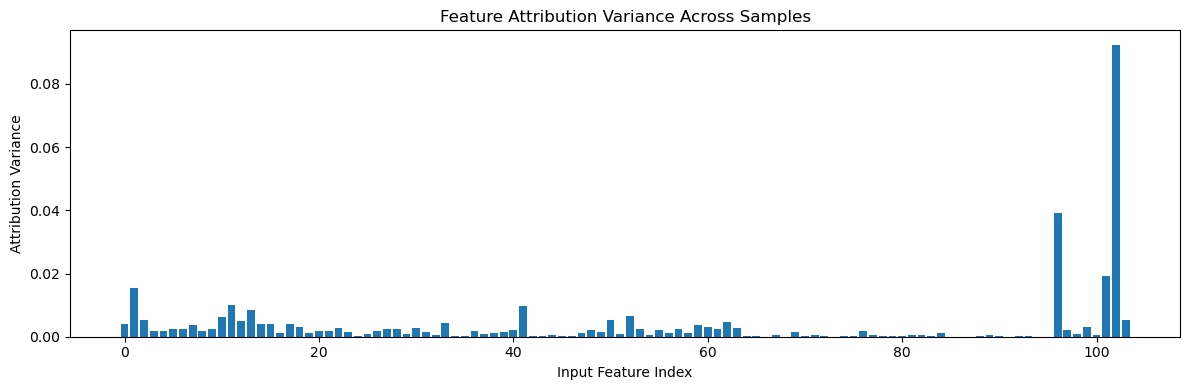

In [163]:
# === Attribution Variance Across Samples === #
attributions_matrix = []
for i in range(50):
    x_cat, x_cont, _ = test_dataset[i]
    x_cat, x_cont = x_cat.unsqueeze(0), x_cont.unsqueeze(0)
    embedded = torch.cat([emb(x_cat[:, j]) for j, emb in enumerate(model.embeddings)], dim=1)
    full_input = torch.cat([embedded, x_cont], dim=1).requires_grad_()
    attr = ig.attribute(full_input, baselines=torch.zeros_like(full_input))
    attributions_matrix.append(attr.detach().cpu().numpy().flatten())

attributions_matrix = np.stack(attributions_matrix)
variances = np.var(attributions_matrix, axis=0)

plt.figure(figsize=(12, 4))
plt.bar(range(len(variances)), variances)
plt.title("Feature Attribution Variance Across Samples")
plt.xlabel("Input Feature Index")
plt.ylabel("Attribution Variance")
plt.tight_layout()
plt.show()